In [ ]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import models
from keras import layers
import pydub
from pydub import AudioSegment
from pydub.utils import which
AudioSegment.converter = which("ffmpeg")
AudioSegment.ffprobe = which("ffprobe")
import math
import random
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import save_model
import PIL
from PIL import ImageFont

In [2]:
SAMPLE_RATE = 22050
N_FFT = 2048
HOP_LENGTH = 512
NUM_SEGMENTS = 10
DATASET_PATH = "dataset_wav"
WINDOW_SIZE = 5

In [3]:
def extract_melspectrogram(data_set, plot_examples=False):
    features = []
    labels = []
    
    # Calculate the number of samples per segment
    num_samples_per_segment = int(SAMPLE_RATE * WINDOW_SIZE)
    
    # Parameters for mel spectrogram
    n_mels = 128  # Number of mel bands (typical value for music)
    fmin = 20     # Minimum frequency
    fmax = 8000   # Maximum frequency (most music information is below 8kHz)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_set)):
        if dirpath != data_set:
            label = dirpath.split("/")[-1]
            print("\nProcessing {}".format(label))

            for filename in filenames:
                file_path = os.path.join(dirpath, filename)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                for s in range(NUM_SEGMENTS):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment

                    # Make sure segment is within bounds
                    if finish_sample <= len(signal):
                        segment = signal[start_sample:finish_sample]
                        
                        # Create mel spectrogram
                        mel_spec = librosa.feature.melspectrogram(
                            y=segment, 
                            sr=SAMPLE_RATE, 
                            n_fft=N_FFT, 
                            hop_length=HOP_LENGTH,
                            n_mels=n_mels,
                            fmin=fmin,
                            fmax=fmax
                        )
                        
                        # Convert to log scale (dB)
                        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
                        
                        # Plot a few examples to verify
                        if plot_examples and len(features) < 3:
                            plt.figure(figsize=(10, 4))
                            librosa.display.specshow(
                                log_mel_spec, 
                                sr=SAMPLE_RATE, 
                                hop_length=HOP_LENGTH,
                                x_axis='time',
                                y_axis='mel',
                                fmin=fmin,
                                fmax=fmax
                            )
                            plt.colorbar(format='%+2.0f dB')
                            plt.title(f'Mel Spectrogram - {label}')
                            plt.tight_layout()
                            plt.savefig(f'mel_spec_example_{len(features)}.png')
                            plt.close()
                        
                        features.append(log_mel_spec)
                        labels.append(label)
                        print("{}, segment:{}".format(file_path, s + 1))

                # Apply the same augmentation techniques
                augmented_signals = augment_audio(signal, sr=SAMPLE_RATE)
                for aug_idx, augmented_signal in enumerate(augmented_signals):
                    for s in range(NUM_SEGMENTS):
                        start_sample = num_samples_per_segment * s
                        finish_sample = start_sample + num_samples_per_segment

                        # Ensure the augmented segment is within bounds
                        if finish_sample <= len(augmented_signal):
                            segment = augmented_signal[start_sample:finish_sample]
                            
                            # Create mel spectrogram from augmented audio
                            mel_spec = librosa.feature.melspectrogram(
                                y=segment, 
                                sr=SAMPLE_RATE, 
                                n_fft=N_FFT, 
                                hop_length=HOP_LENGTH,
                                n_mels=n_mels,
                                fmin=fmin,
                                fmax=fmax
                            )
                            
                            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
                            
                            features.append(log_mel_spec)
                            labels.append(label)
                            print("Augmented {}, {}, segment:{}".format(aug_idx, file_path, s + 1))

    return np.array(features), np.array(labels)


def augment_audio(signal, sr):
    # Time stretching (slower to faster)
    rate = random.uniform(0.8, 1.2)
    stretched_signal = librosa.effects.time_stretch(signal, rate=rate)

    # Pitch shifting (higher/lower pitch)
    steps = random.randint(-3, 3)  # Reduced range for more realistic augmentation
    shifted_signal = librosa.effects.pitch_shift(signal, sr=sr, n_steps=steps)

    # Adding noise (subtle background noise)
    noise_factor = 0.003  # Reduced noise for better quality
    noise = np.random.randn(len(signal))
    noisy_signal = signal + noise_factor * noise

    return [stretched_signal, shifted_signal, noisy_signal]

# Print a message to indicate processing has started
print("Starting feature extraction...")
spectrograms, labels = extract_melspectrogram(DATASET_PATH, plot_examples=True)


Starting feature extraction...

Processing dataset_wav\Ardhito Pramono_Dancing In September
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:1
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:2
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:3
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:4
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:5
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:6
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:7
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:8
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:9

In [4]:
print(f"Extracted {len(spectrograms)} spectrogram features")
print(f"Spectrogram shape: {spectrograms[0].shape}")

original_shape = spectrograms.shape
reshaped_specs = spectrograms.reshape(original_shape[0], -1)

scaler = MinMaxScaler()
scaled_specs = scaler.fit_transform(reshaped_specs)

spectrograms = scaled_specs.reshape(original_shape)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

num_classes = len(np.unique(encoded_labels))
print(f"Number of classes: {num_classes}")
for i in range(num_classes):
    count = np.sum(encoded_labels == i)
    print(f"Class {i} ({label_encoder.inverse_transform([i])[0]}): {count} samples")

Extracted 898 spectrogram features
Spectrogram shape: (128, 216)
Number of classes: 12
Class 0 (dataset_wav\Ardhito Pramono_Dancing In September): 76 samples
Class 1 (dataset_wav\Ed Sheeran_Supermarket Flowers): 74 samples
Class 2 (dataset_wav\GANGGA_Whiskey Bottle): 79 samples
Class 3 (dataset_wav\Giveon_Heartbreak Anniversary): 78 samples
Class 4 (dataset_wav\Gracie Abrams_That’s So True): 73 samples
Class 5 (dataset_wav\Keshi_UNDERSTAND): 74 samples
Class 6 (dataset_wav\Labrinth_Jealous): 75 samples
Class 7 (dataset_wav\Lady Gaga_Die With A Smile): 73 samples
Class 8 (dataset_wav\Lauv_First Heartbreak): 74 samples
Class 9 (dataset_wav\Lukas Graham_Love Someone): 75 samples
Class 10 (dataset_wav\Rich Brian_100 Degrees): 73 samples
Class 11 (dataset_wav\Ricky Montgomery_This December): 74 samples


In [5]:
spectrograms = spectrograms[..., np.newaxis]

# Split the data with stratification
x_train, x_temp, y_train, y_temp = train_test_split(
    spectrograms, encoded_labels, 
    test_size=0.4, 
    random_state=42, 
    shuffle=True,
    stratify=encoded_labels  # Ensure balanced classes in splits
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, 
    test_size=0.5, 
    random_state=42, 
    shuffle=True,
    stratify=y_temp
)
print(f"Training set: {x_train.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")
print(f"Test set: {x_test.shape[0]} samples")

Training set: 538 samples
Validation set: 180 samples
Test set: 180 samples


In [6]:
def create_improved_model(input_shape, num_classes):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Fourth convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dropout(0.3),  # Regularization
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),  # Regularization
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [7]:
input_shape = x_train.shape[1:]
print(f"Input shape: {input_shape}")

# Create and compile the model
model = create_improved_model(input_shape, num_classes)
model.summary()

Input shape: (128, 216, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 216, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 108, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 27, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 13, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 13, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,408,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,652,876 (13.93 MB)

 Trainable params: 3,652,172 (13.93 MB)

 Non-trainable params: 704 (2.75 KB)

In [8]:
try:
    font = ImageFont.truetype("arial.ttf", 12)
    import visualkeras
    visualkeras.layered_view(model, legend=True, font=font).show()
except Exception as e:
    print(f"Could not visualize model: {e}")

# Compile with appropriate learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.00025)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


c:\Users\KR24-1.SOFTWARELABCNTR\AppData\Local\Programs\Python\Python310\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [9]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,  # More gentle reduction
    patience=5,   # Adjust more frequently
    min_lr=0.00001, 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,  # More patience
    restore_best_weights=True,  # Important: restore best weights
    verbose=1
)

class_weights = {}
total_samples = len(y_train)
for i in range(num_classes):
    class_count = np.sum(y_train == i)
    class_weights[i] = total_samples / (num_classes * class_count)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,  # More epochs with early stopping
    batch_size=16,  # Smaller batch size for better gradient estimates
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weights,  # Handle class imbalance
    verbose=1
)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 288ms/step - accuracy: 0.3290 - loss: 2.7353 - val_accuracy: 0.0833 - val_loss: 2.8693 - learning_rate: 2.5000e-04
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step - accuracy: 0.8343 - loss: 0.5377 - val_accuracy: 0.0833 - val_loss: 3.8320 - learning_rate: 2.5000e-04
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - accuracy: 0.9512 - loss: 0.1777 - val_accuracy: 0.0833 - val_loss: 5.3583 - learning_rate: 2.5000e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - accuracy: 0.9683 - loss: 0.0880 - val_accuracy: 0.0833 - val_loss: 7.0375 - learning_rate: 2.5000e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.9863 - loss: 0.0495 - val_accuracy: 0.0833 - val_loss: 5.7278 - learning_rate: 2.5000e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9924 - loss: 0.0376
Epoch 6: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step - ac

In [10]:
score = model.evaluate(x_test, y_test)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.1163 - loss: 2.8001
Test loss: 2.8768835067749023
Test accuracy: 0.08888889104127884


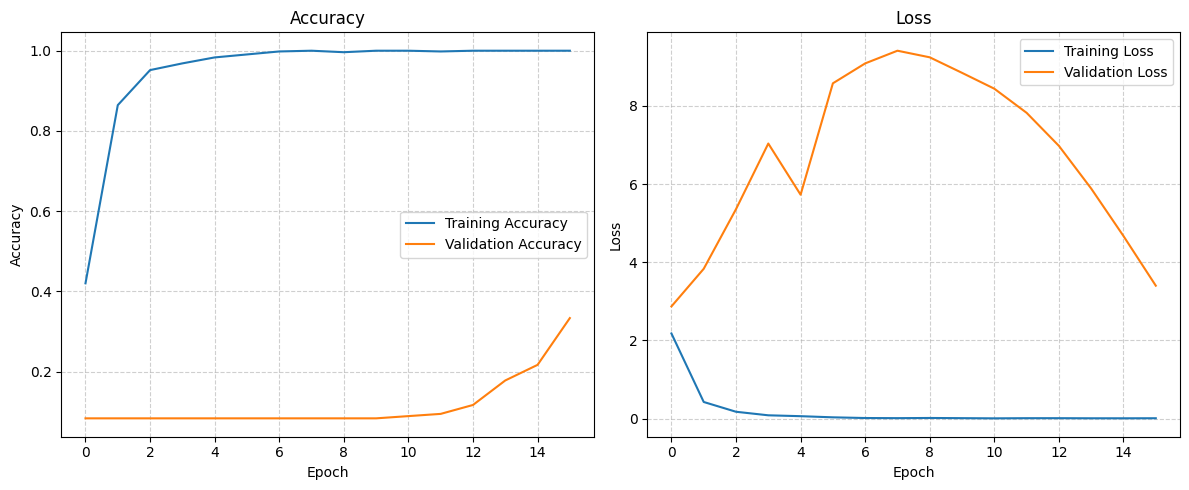

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('improved_melspectrogram_metrics.png')
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred = np.argmax(model.predict(x_test), axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('melspectrogram_confusion_matrix.png')
plt.show()

# Print classification report
print("\nClassification Report:")
report = classification_report(
    y_test, 
    y_pred, 
    target_names=label_encoder.classes_
)
print(report)

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
def predict_song_melspectrogram(file_path, model, label_encoder):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    num_samples_per_segment = int(SAMPLE_RATE * WINDOW_SIZE)
    
    # Parameters for mel spectrogram (same as training)
    n_mels = 128
    fmin = 20
    fmax = 8000
    
    predictions = []
    
    # Process segments
    for s in range(min(NUM_SEGMENTS, math.ceil(len(signal) / num_samples_per_segment))):
        start_sample = num_samples_per_segment * s
        end_sample = min(start_sample + num_samples_per_segment, len(signal))
        
        # Handle final segment that might be shorter
        if end_sample - start_sample < num_samples_per_segment:
            # Pad with zeros
            segment = np.pad(signal[start_sample:end_sample], 
                            (0, num_samples_per_segment - (end_sample - start_sample)))
        else:
            segment = signal[start_sample:end_sample]
        
        # Create mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=segment, 
            sr=SAMPLE_RATE, 
            n_fft=N_FFT, 
            hop_length=HOP_LENGTH,
            n_mels=n_mels,
            fmin=fmin,
            fmax=fmax
        )
        
        # Convert to log scale (dB)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Normalize using the same approach as during training
        min_val = np.min(log_mel_spec)
        max_val = np.max(log_mel_spec)
        normalized_spec = (log_mel_spec - min_val) / (max_val - min_val)
        
        # Add batch and channel dimensions
        spec_input = normalized_spec[np.newaxis, ..., np.newaxis]
        
        # Predict
        prediction = model.predict(spec_input)
        predicted_label = np.argmax(prediction)
        predictions.append(predicted_label)
    
    # Find most common prediction
    from collections import Counter
    prediction_counts = Counter(predictions)
    most_common_label = prediction_counts.most_common(1)[0][0]
    
    # Get confidence (percentage of segments with this prediction)
    confidence = prediction_counts[most_common_label] / len(predictions) * 100
    
    # Get predicted song name
    predicted_song = label_encoder.inverse_transform([most_common_label])[0]
    
    # Extract artist and song name
    try:
        path_parts = predicted_song.split("\\")[-1]
        if "_" in path_parts:
            artist, song = path_parts.split("_", 1)
        else:
            artist = "Unknown"
            song = path_parts
    except:
        artist = "Unknown"
        song = predicted_song
    
    return artist, song, confidence, predictions

# Test the prediction function
test_file_path = "dataset_wav/GANGGA_Whiskey Bottle/GANGGA_Whiskey Bottle_segment_5.wav"
artist, song, confidence, raw_predictions = predict_song_melspectrogram(test_file_path, model, label_encoder)
print(f"Predicted Artist: {artist}")
print(f"Predicted Song: {song}")
print(f"Confidence: {confidence:.2f}%")
print(f"Raw predictions: {raw_predictions}")